In [1]:
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline

# El método de Numerov

El método de Numerov está diseñado para resolver el ecuaciones de segundo grado de la forma
$$ \frac{d^2 y(x)}{dx^2} = -g(x) y(x) + s(x)$$

Donde $g(x)$ y $s(x)$ son funciones conocidas.

Para resolver numéricamente la ecuación diferencial primero hay que discretizar el espacio y luego las funciones. Por lo tanto denotamos $f(x) = f(n\Delta x) = f_n$. Donde $n$ es un entero y $\Delta x$ es el espaciamiento entre los muntos de la malla.

El esquema de Numerov se puede escribir como:

$$
y_{n+1} \left( 1+ g_{n+1} \frac{(\Delta x)^2}{12}\right) = 2y_n \left( 1+ g_n \frac{5(\Delta x)^2}{12}\right) -
y_{n-1} \left( 1+ g_{n-1} \frac{(\Delta x)^2}{12}\right) + \left(s_{n+1}+10s_n+s_{n-1}\right)\frac{(\Delta x)^2}{12} + O\left((\Delta x)^6\right)
$$

Esta relación se puede simplificar si definimos $f_n = 1+g_n \frac{(\Delta x)^2}{12}$, ya que se puede escribir

$$ y_{n+1} = \frac{(12-10f_n)y_n - f_{n-1}y_{n-1}}{f_{n+1}}+ \left(s_{n+1}+10s_n+s_{n-1}\right)\frac{(\Delta x)^2}{12} + O\left((\Delta x)^6\right)
$$

Notemos que si queremos resolver la ecuación de Schödinger estacionaria (en 1D por ahora) por el método de Numerov
$$ \frac{d^2\ \psi}{dx^2} = \frac{2m}{\hbar^2}\left[V(x)-E\right]\ \psi$$

Debemos hacer la correpondencia 

\begin{array}
\\g(x) &= \frac{2m}{\hbar^2}\left[E-V(x)\right]\\ 
s(x) &= 0
\end{array}

Por lo tanto el esquema que se va a implementar es de la forma

$$ y_{n+1} = \frac{(12-10f_n)y_n - f_{n-1}y_{n-1}}{f_{n+1}} + O\left((\Delta x)^6\right)
$$

Donde $f_n = 1+g_n \frac{(\Delta x)^2}{12}$ con $g_n = \frac{2m}{\hbar^2}\left[E-V_n\right]$

**Notemos que para ejecutar el algoritmo de Numerov debemos de conocer $y(0)$ y $y(1)$ como condiciones iniciales.**

## Una partícula en un pozo de potencial infinito

Consideremos el caso en que tenemos una caja de potencial, es decir 
\begin{array}\\
V(x) = 0\text{ si |x| < 1}\\
V(x) = \infty \text{ si |x| > 1}
\end{array}

Teniendo ese potencial nos obliga a tener las siguientes condiciones a la frontera
$$\psi(x) = 0\text{ si |x| = 1}$$

In [2]:
def Numerov(g,  p_ini, x, dx=0.1):
    y = zeros(len(x))
    y[0] = p_ini[0]
    y[1] = p_ini[1]
    
    f = ones(len(x)) + (dx*dx/12.0)*g
    for i in range(2, len(x)):
        y[i] = ((12.0-10.0*f[i-1])*y[i-1]-f[i-2]*y[i-2])/f[i]

    return y

def g_func(potencial, E, x):
    return 2.0*(E*ones(len(x)) - potencial(x))

def NumerovEnergyShooting_caja(potencial, p_ini, x_def, E_def, dx=0.01, dE = 0.1, epsilon=1.0e-4):
    x = arange(x_def[0], x_def[1]+dx, dx)
    e = E_def[0]
    y = Numerov(g_func(potencial, e, x),  p_ini, x, dx)
    
    sign = y[-1]
    sign_temp = sign
    
    paso = False
    
    while (abs(y[-1])>epsilon):
        if sign_temp*sign < 0 or paso:
            if paso == False:
                E = [e-dE, e]
                paso = True
            else:
                if y[-1] < 0:
                    if y[-1]-y[-2]<0:
                        E = [E[0], e]
                    else:
                        E = [e, E[1]]
                else:
                    if y[-1]-y[-2]<0:
                        E = [e, E[1]]
                    else:
                        E = [E[0], e]

            e = 0.5*(E[0]+E[1])
            y = Numerov(g_func(potencial, e, x),  p_ini, x, dx)
        else:
            sign_temp = sign.copy()
            e = e + dE
            y = Numerov(g_func(potencial, e, x),  p_ini, x, dx)        
            sign = y[-1]
            
        norm = 0.0
        for i in range(len(x)):
            norm += y[i]*y[i]
        norm = norm*dx
        
        y = y/sqrt(norm)
    return e, x, y

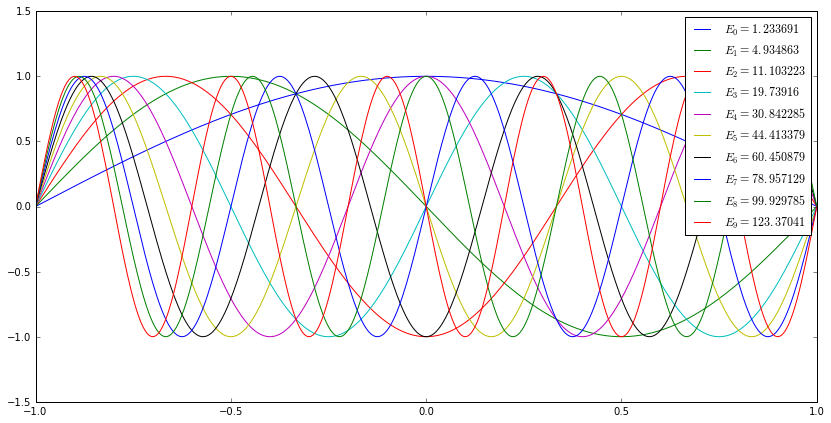

In [3]:
def pot1(x):
    return zeros(len(x))

fig = figure(figsize=(14,7))
ax = fig.add_subplot(111)

e = 0.0
x_max = 1.0
for i in range(10):
    e_temp = e
    e, x, y = NumerovEnergyShooting_caja(pot1, array([0.0, 1.0]), array([-x_max, x_max]), 
                                    array([e_temp+0.1, 100.0]), 0.005, 0.1, 1.0e-4)
    ax.plot(x, y, label="$E_{"+str(i)+"} = "+str(round(e,6))+"$")

ax.legend()
ax.set_xlim(-1,1);

## En un pozo finito de potencial

In [4]:
def NumerovEnergyShooting_pozo(potencial, p_ini, x_def, E_def, dx=0.01, dE = 0.1, epsilon=1.0e-4):
    x = arange(x_def[0], x_def[1]+dx, dx)
    e = E_def[0]
    y = Numerov(g_func(potencial, e, x),  p_ini, x, dx)
    
    sign = y[-1]
    sign_temp = sign
    
    paso = False
    
    while (abs(y[-1])>epsilon):
        if sign_temp*sign < 0 or paso:
            if paso == False:
                E = [e-dE, e]
                paso = True
            else:
                if y[-1] < 0:
                    if y[-1]-y[-2]<0:
                        E = [E[0], e]
                    else:
                        E = [e, E[1]]
                else:
                    if y[-1]-y[-2]<0:
                        E = [e, E[1]]
                    else:
                        E = [E[0], e]

            e = 0.5*(E[0]+E[1])
            y = Numerov(g_func(potencial, e, x),  p_ini, x, dx)
        else:
            sign_temp = sign.copy()
            e = e + dE
            y = Numerov(g_func(potencial, e, x),  p_ini, x, dx)        
            sign = y[-1]
            
        norm = 0.0
        for i in range(len(x)):
            norm += y[i]*y[i]
        norm = norm*dx
        
        y = y/sqrt(norm)
    return e, x, y

### Si E > 0

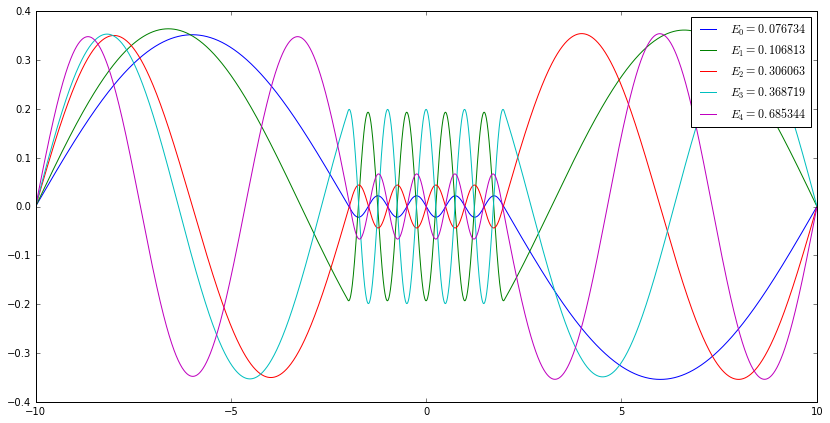

In [16]:
def pot2(x):
    pot = zeros(len(x))
    for i in range(len(x)):
        if abs(x[i]) < 2:
            pot[i] = -20
        else:
            pot[i] = 0
            
    return pot

fig = figure(figsize=(14,7))
ax = fig.add_subplot(111)

dx = 0.005
dE = 0.001
x_max = 10.0
x = arange(-x_max, x_max+dx, dx)
e = 0

for i in range(5):
    e_temp = e
    e, x, y = NumerovEnergyShooting_pozo(pot2, array([0.0, 1.0]), array([-x_max, x_max]), 
                                         array([e_temp+dE, 100.0]),dx, dE, 1.0e-4)
    
    ax.plot(x, y, label="$E_{"+str(i)+"} = "+str(round(e,6))+"$")

ax.legend()
ax.set_xlim(-x_max, x_max);

### Si E < 0

In [ ]:
def pot2(x):
    pot = zeros(len(x))
    for i in range(len(x)):
        if abs(x[i]) < 2:
            pot[i] = -100
        else:
            pot[i] = 0
            
    return pot

fig = figure(figsize=(14,7))
ax = fig.add_subplot(111)

dx = 0.005
dE = 0.01
x_max = 20.0
x = arange(-x_max, x_max+dx, dx)
e = -1

for i in range(10):
    e_temp = e
    e, x, y = NumerovEnergyShooting_pozo(pot2, array([1.0, 2.0]), array([-x_max, x_max]), array([e_temp+dE, 0.0]),
                                    dx, dE, 1.0e-4)
    ax.plot(x, y, label="$E_{"+str(i)+"} = "+str(round(e,6))+"$")

ax.legend()
ax.set_xlim(-x_max, x_max);